In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sqlite3

In [3]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'
MINIMUM_NUMBER_OF_RUNS = 3

In [4]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [5]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


#### look at e.coli only that appear in more half the runs in the experiment

In [9]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select * from features order by intensity desc', db_conn)
db_conn.close()


DatabaseError: Execution failed on sql 'select * from features order by intensity desc': database or disk is full

In [6]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [7]:
sequences_df[['sequence','charge','intensity','file_idx']].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,intensity,file_idx
8569,YLLLQQFSNPANPEIHEK,3,9536,4
28245,EPDYLDIPAFLR,2,3008,1
36295,LIAAAPTAVAPEESGFYAR,2,2202,6
57838,QTYCGPIGAEYMHITSTEEK,3,1082,8
60511,LTAPESNLEVSYQNYHR,2,994,4
62065,EGQEVIVQIDKEER,2,943,11
63892,GGTVLNIPQQLILPDTVHEGIVINSAEMR,3,882,9
70811,ADGAMDAGNMLKPALAR,2,676,1
75335,ALNSVEASQPHQDQMEK,2,547,8
84374,CAGFNNVDLDAAK,2,289,8


#### analyse a selected sequence across the experiment for runs in which it was classified as a target

In [58]:
selected_sequence = 'EPDYLDIPAFLR'
selected_sequence_charge = 2

In [59]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

#### compare the intensities across the experiment for the selected sequence

In [60]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

In [61]:
MAX_SUMMED_APEX_POINTS = 3 * 3000

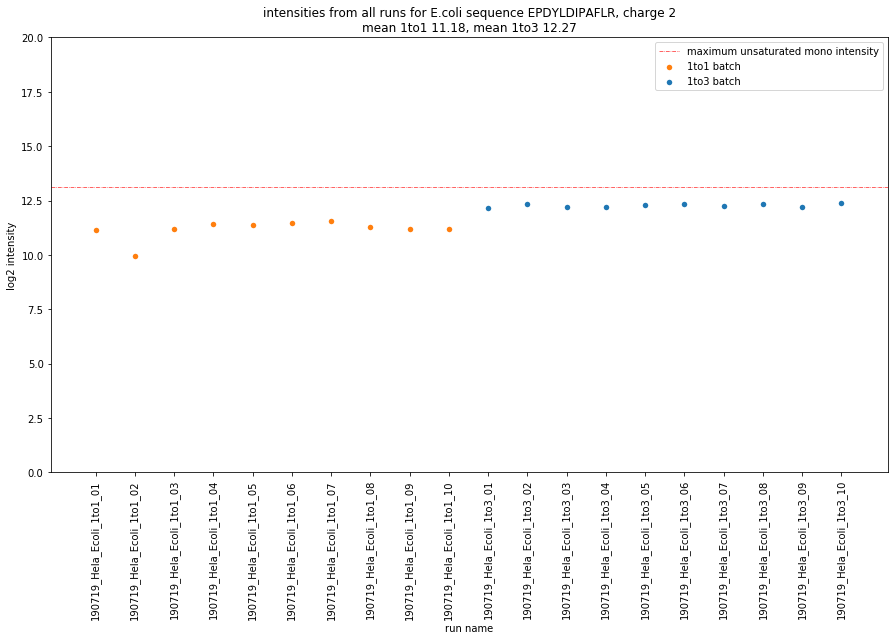

In [62]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity)), 2)

plt.title('intensities from all runs for E.coli sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, selected_sequence_1to1_df.log_intensity, marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1 batch')
ax1.scatter(selected_sequence_1to3_df.run_name, selected_sequence_1to3_df.log_intensity, marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3 batch')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to1) > 0:
    ax1.plot(adj_sat_1to1.run_name, adj_sat_1to1.log_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='inferred intensity')

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to3) > 0:
    ax1.plot(adj_sat_1to3.run_name, adj_sat_1to3.log_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='_nolegend_')

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, row.log_intensity+2.1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, row.log_intensity+2.1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)

plt.axhline(y=np.log2(MAX_SUMMED_APEX_POINTS), color='red', linestyle='-.', linewidth=0.6, label='maximum unsaturated mono intensity')

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of e.coli intensity deltas for sequences in 1to1 runs 01 and 02

In [63]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [64]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [65]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

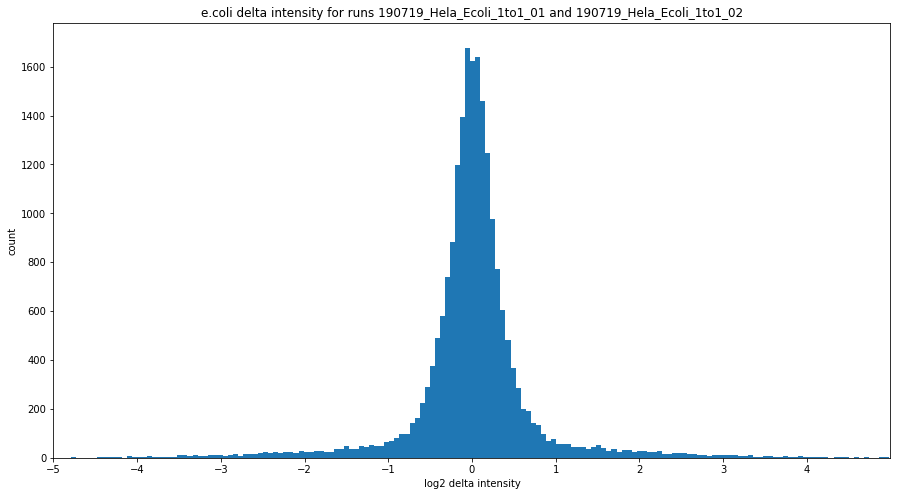

In [66]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('e.coli delta intensity for runs {} and {}'.format(run_A, run_B))
ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [67]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_extracted >= MINIMUM_NUMBER_OF_RUNS)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_medians_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.batch.unique()) == 2:
        batch_1to1_median = group_df[group_df.batch == '1to1'].intensity.median()
        batch_1to3_median = group_df[group_df.batch == '1to3'].intensity.median()
        batch_medians_l.append((group_name[0], group_name[1], batch_1to1_median, batch_1to3_median))
batch_medians_df = pd.DataFrame(batch_medians_l, columns=['sequence','charge','batch_1to1_median','batch_1to3_median'])
batch_medians_df['log_batch_1to1_median'] = np.log2(batch_medians_df.batch_1to1_median)
batch_medians_df['log_batch_1to3_median'] = np.log2(batch_medians_df.batch_1to3_median)
batch_medians_df['delta_log_median'] = batch_medians_df.log_batch_1to3_median - batch_medians_df.log_batch_1to1_median

In [68]:
batch_medians_df.sample(n=5)

,sequence,charge,batch_1to1_median,batch_1to3_median,log_batch_1to1_median,log_batch_1to3_median,delta_log_median
3891,SLLKPEHQGLATEVMCR,2,513.0,850.0,9.002815,9.731319,0.728504
713,DICQCEALWTPAK,2,526.5,907.0,9.040290,9.824959,0.784669
1406,FGEAIELLEQGDK,2,1595.0,1233.0,10.639341,10.267957,-0.371384
274,AIVQLEDGVQISSGDTLAR,2,2273.0,2573.0,11.150382,11.329236,0.178854
3302,NKFPAFTGELPNGDQYYGFPAENDALK,3,300.5,615.0,8.231221,9.264443,1.033221


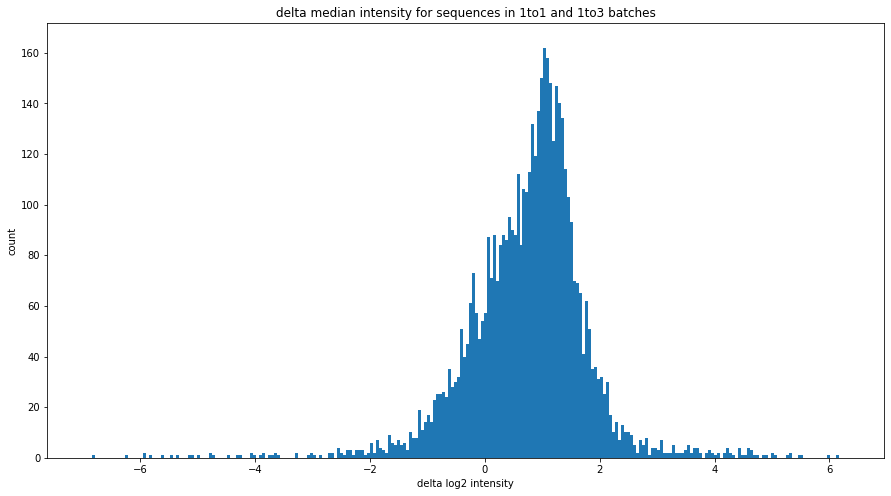

In [69]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_medians_df.delta_log_median, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta median intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [70]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_extracted >= MINIMUM_NUMBER_OF_RUNS)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_means_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.batch.unique()) == 2:
        batch_1to1_mean = group_df[group_df.batch == '1to1'].intensity.mean()
        batch_1to3_mean = group_df[group_df.batch == '1to3'].intensity.mean()
        batch_means_l.append((group_name[0], group_name[1], batch_1to1_mean, batch_1to3_mean))
batch_means_df = pd.DataFrame(batch_means_l, columns=['sequence','charge','batch_1to1_mean','batch_1to3_mean'])
batch_means_df['log_batch_1to1_mean'] = np.log2(batch_means_df.batch_1to1_mean)
batch_means_df['log_batch_1to3_mean'] = np.log2(batch_means_df.batch_1to3_mean)
batch_means_df['delta_log_mean'] = batch_means_df.log_batch_1to3_mean - batch_means_df.log_batch_1to1_mean

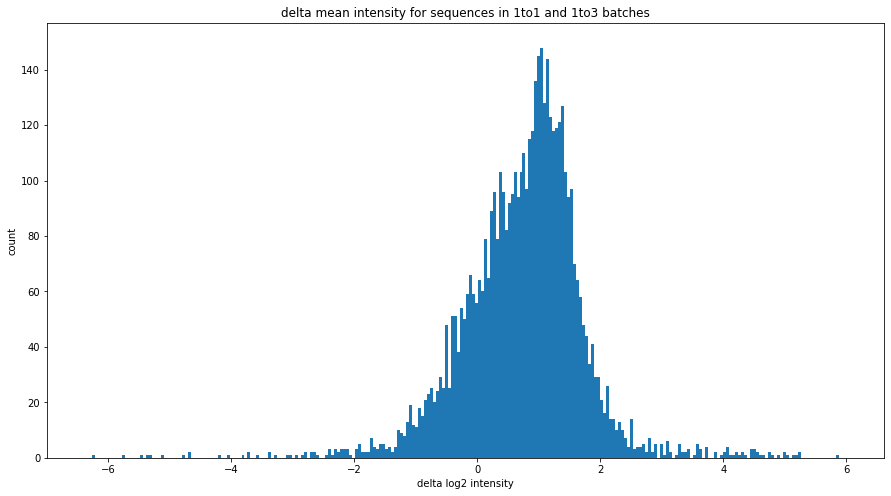

In [71]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_means_df.delta_log_mean, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta mean intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

#### look at all sequences - human and e.coli

In [72]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,number_of_runs_extracted,human,run_name,batch,intensity,isotope_idx_not_in_saturation from features order by intensity desc', db_conn)
db_conn.close()


In [73]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [74]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [75]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [76]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

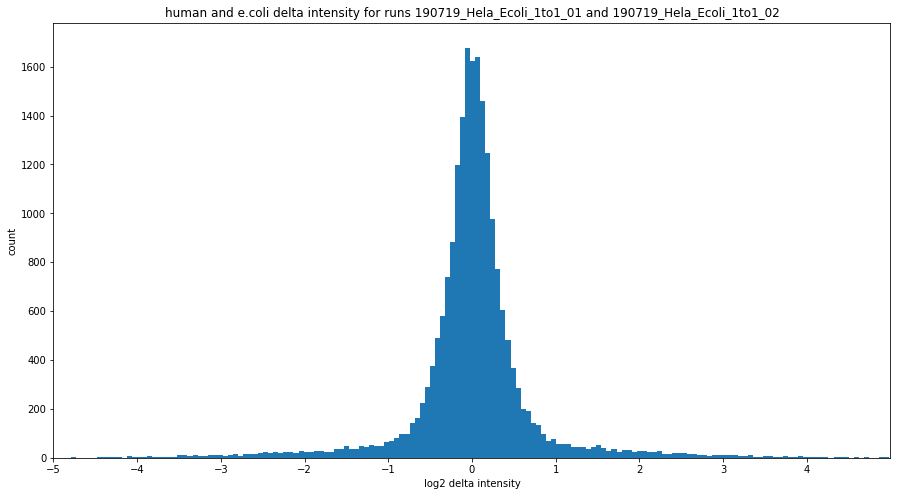

In [77]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('human and e.coli delta intensity for runs {} and {}'.format(run_A, run_B))
ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [78]:
sequences_in_both_runs_df.columns

Index(['sequence', 'charge', 'file_idx_x', 'peak_idx_x',
       'number_of_runs_extracted_x', 'human_x', 'run_name_x', 'batch_x',
       'intensity_x', 'isotope_idx_not_in_saturation_x', 'log_intensity_x',
       'file_idx_y', 'peak_idx_y', 'number_of_runs_extracted_y', 'human_y',
       'run_name_y', 'batch_y', 'intensity_y',
       'isotope_idx_not_in_saturation_y', 'log_intensity_y',
       'delta_log_intensity'],
      dtype='object')

In [79]:
human_df = sequences_in_both_runs_df[sequences_in_both_runs_df.human_x == True]
ecoli_df = sequences_in_both_runs_df[sequences_in_both_runs_df.human_x == False]

In [80]:
linear_df = pd.DataFrame([(1.5,1.5),(5.5,5.5)], columns=['one_to_one','one_to_three'])

In [81]:
linear_df

,one_to_one,one_to_three
0,1.5,1.5
1,5.5,5.5


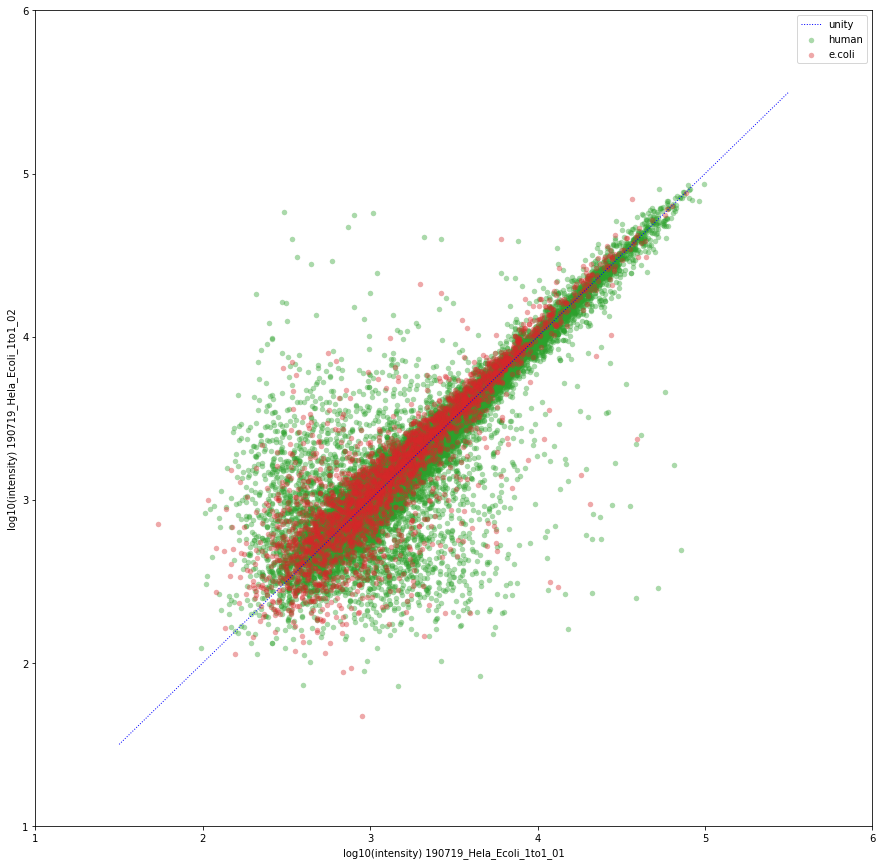

In [82]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

# title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
# plt.title(title)

ax.scatter(np.log10(human_df.intensity_x), np.log10(human_df.intensity_y), marker='o', color='tab:green', lw=0, s=30, alpha=0.4, label='human')
ax.scatter(np.log10(ecoli_df.intensity_x), np.log10(ecoli_df.intensity_y), marker='o', color='tab:red', lw=0, s=30, alpha=0.4, label='e.coli')

ax.plot(linear_df.one_to_one, linear_df.one_to_three, marker='', color='blue', linestyle=':', linewidth=1, ms=5, label='unity')

plt.legend(loc='best')
plt.xlabel('log10(intensity) {}'.format(run_A))
plt.ylabel('log10(intensity) {}'.format(run_B))

plt.xlim((1,6))
plt.ylim((1,6))

plt.show()